# 1. Imports

In [1]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime



# 2. Settings

In [2]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
plt.style.use('ggplot')
RANDOM_SEED = 0

# 3. Loading Data

In [3]:
def read_transport_data(filename):
    types_mapping = {
        'Numer / oznaczenie linii' : str,                                     
        'Wariant linii' : str,                                              
        'Kurs' : str,                                                        
        'Oznaczenie brygady' : str,
        'Czas rzeczywisty odjazdu wg. rozkładu' : str,                              
        'Czas odjazdu z przystanku' : str,
    }

    df = pd.read_csv(filename, sep=';', dtype=types_mapping)
    df = df.drop(columns='Data')
    
    names_mapping = {
        'Numer / oznaczenie linii' : 'Nr linii',                                     
        # 'Wariant linii'                                                    
        # 'Kurs'                                                                
        # 'Oznaczenie brygady'                                                  
        # 'Numer taborowy'                                                     
        # 'Nazwa przystanku'                                                    
        # 'Numer przystanku'                                                   
        'Czas rzeczywisty odjazdu wg. rozkładu' : 'Rzeczywisty czas odjazdu',                              
        'Czas odjazdu z przystanku' : 'Rozkładowy czas odjazdu',                                      
        'Liczba pasażerów w pojeździe przed przystankiem (dane skorygowane)' : 'Liczba pasaz. przed',  
        'Liczba osób które wysiadły (dane skorygowane)' : 'Liczba wysiadających pasaz.',                       
        'Liczba osób które wsiadły (dane skorygowane)' : 'Liczba wsiadajacych pasaz.',                     
        'Liczba pasażerów w pojeździe po odjeździe (dane skorygowane)' : 'Liczba pasaz. po odjezdzie'
    }
    df.rename(columns=names_mapping, inplace=True)

    

    return df

In [4]:
df = read_transport_data('./data/SZP-2021-09-03.csv')

# 4. Inspecting Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177546 entries, 0 to 177545
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Nr linii                     177546 non-null  object
 1   Wariant linii                177546 non-null  object
 2   Kurs                         177546 non-null  object
 3   Oznaczenie brygady           177546 non-null  object
 4   Numer taborowy               177546 non-null  int64 
 5   Nazwa przystanku             177546 non-null  object
 6   Numer przystanku             177546 non-null  int64 
 7   Rzeczywisty czas odjazdu     172273 non-null  object
 8   Rozkładowy czas odjazdu      177546 non-null  object
 9   Liczba pasaz. przed          177546 non-null  int64 
 10  Liczba wysiadających pasaz.  177546 non-null  int64 
 11  Liczba wsiadajacych pasaz.   177546 non-null  int64 
 12  Liczba pasaz. po odjezdzie   177546 non-null  int64 
dtypes: int64(6), o

In [6]:
df.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
49938,159,Nie dotyczy,00:00,4,9531,Mokotowska,1,NaN,17:31,14,3,0,11
19401,127,TP-MAT,13:10,3,9821,Płużańska,1,13:17:00,13:22,12,1,2,13
35898,149,TP-KOL,11:59,4,9536,Góralska,1,12:18:00,12:18,17,0,3,20
88847,197,TP-CMW,08:29,14,9458,Koło,4,08:45:00,08:45,12,1,1,12
35671,149,TP-KOL,21:01,3,9534,Bemowo-Ratusz,1,21:14:00,21:14,26,3,2,25


In [7]:
df.describe()

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
count,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000
mean,9513.375953,3.437903,12.060711,1.560435,1.570534,12.070810
std,265.044802,7.857952,12.341741,3.136487,3.192504,12.335713
min,9061.000000,1.000000,-3.000000,0.000000,0.000000,0.000000
25%,9319.000000,1.000000,4.000000,0.000000,0.000000,4.000000
50%,9452.000000,2.000000,9.000000,0.000000,0.000000,9.000000
75%,9806.000000,3.000000,16.000000,2.000000,2.000000,16.000000
max,9955.000000,88.000000,133.000000,124.000000,110.000000,133.000000


# 4.1. Check data

In [8]:
counter = 0
counter += len(df.loc[df['Liczba pasaz. przed'] - df['Liczba wysiadających pasaz.'] + df['Liczba wsiadajacych pasaz.'] != df['Liczba pasaz. po odjezdzie']])
counter += len(df[df['Liczba pasaz. przed'] < 0])
print(f'Amount of invalid data: {counter}')

Amount of invalid data: 2


# 4.2. Remove errors

In [9]:
df.drop(df[df['Liczba pasaz. przed'] < 0].index, inplace=True) # remove invlid amout of passengers

df.drop(df[df['Kurs'].str[:2] > '23'].index, inplace= True)

is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

df.drop(df[row_has_NaN].index, inplace=True)


# 4.3. Parse data

In [10]:
def make_date_one_type(x):
    return pd.Timestamp(x)

In [11]:
df['Kurs'] = df['Kurs'].apply(lambda x: make_date_one_type(x))
df['Rzeczywisty czas odjazdu'] = df['Rzeczywisty czas odjazdu'].apply(lambda x: make_date_one_type(x))
df['Rozkładowy czas odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: make_date_one_type(x))

# 4.4. New data

In [12]:
trans_type = []
for nr in df['Nr linii']:
    if nr.isnumeric():
        trans_type.append('autobus')
    elif nr[0] == 'N':
        trans_type.append('nocny')
    elif nr[0] == 'Z':
        trans_type.append('zastepczy')
    else:
        trans_type.append('inny')
df['Typ'] = trans_type

# 5. Exploratory Data Analysis (EDA)

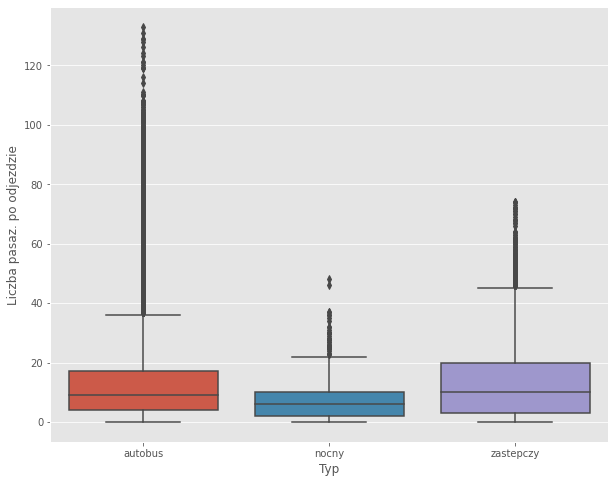

In [13]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    y='Liczba pasaz. po odjezdzie',
    x='Typ',
    data=df
)

<Figure size 432x288 with 0 Axes>

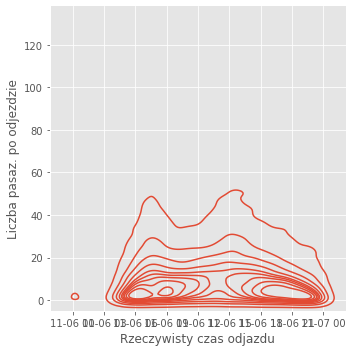

In [14]:
plt.figure()
ax = sns.displot(
    df,
    x='Rzeczywisty czas odjazdu',
    y='Liczba pasaz. po odjezdzie',
    kind='kde'
)

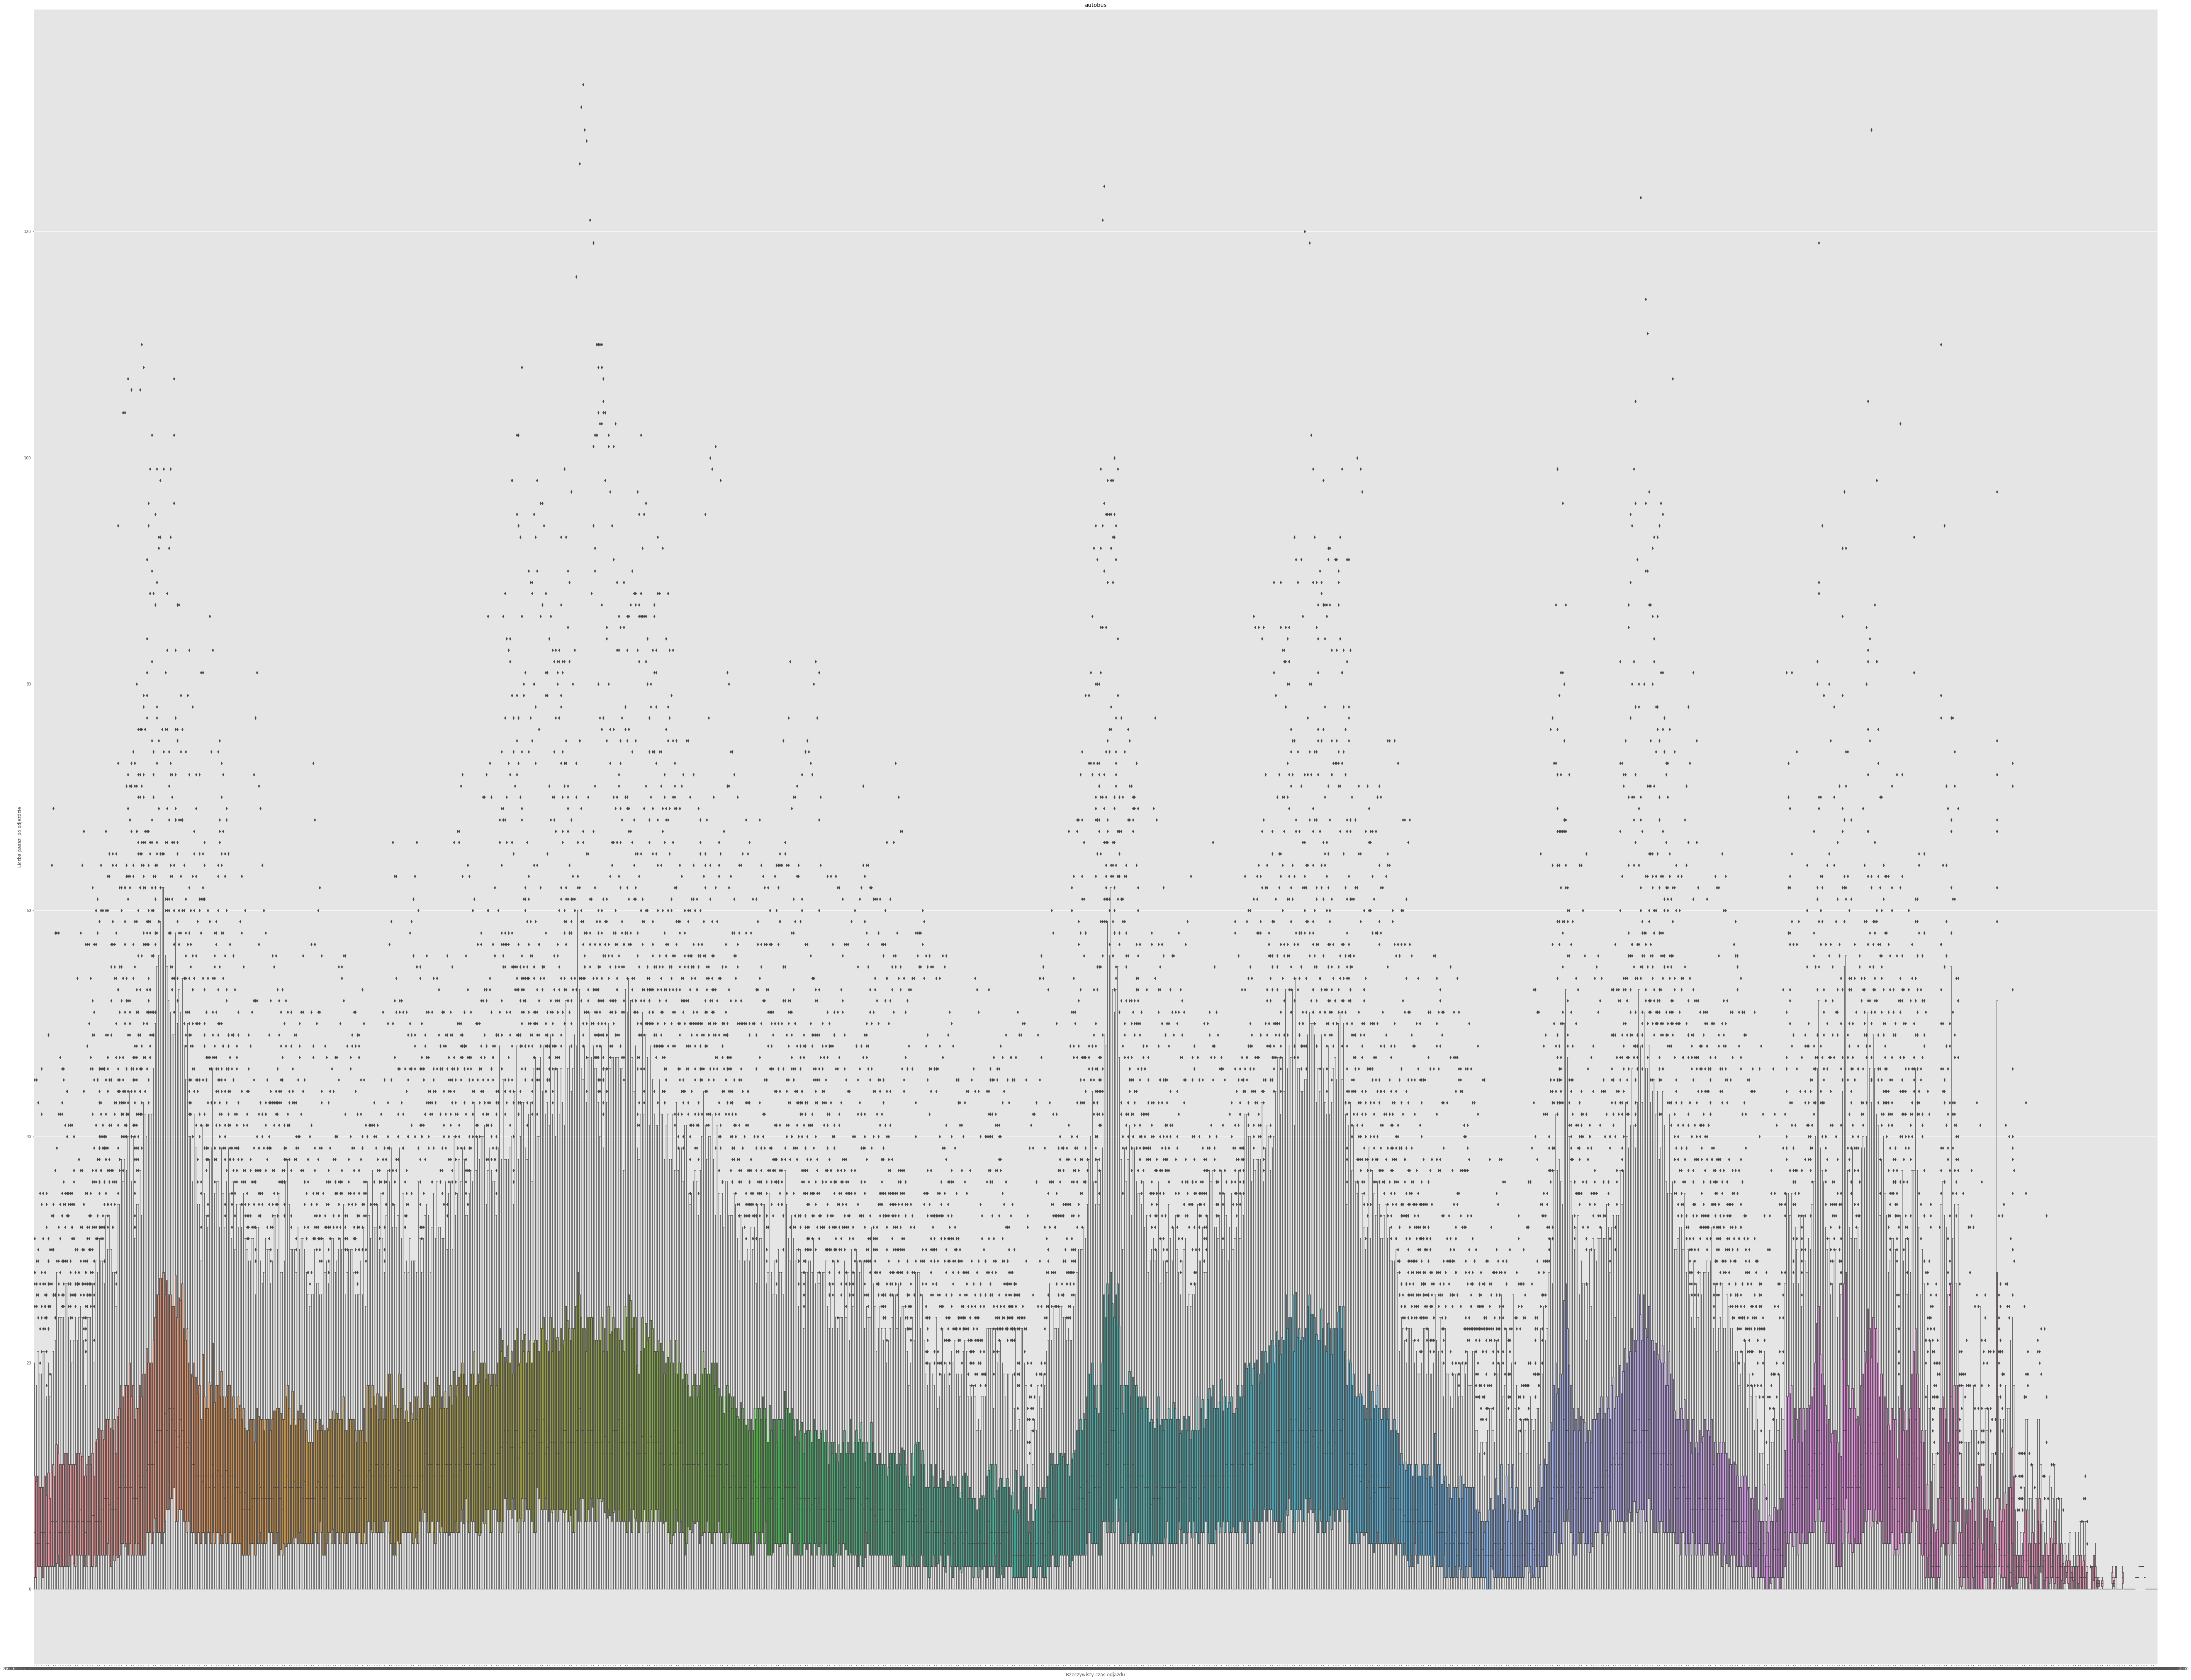

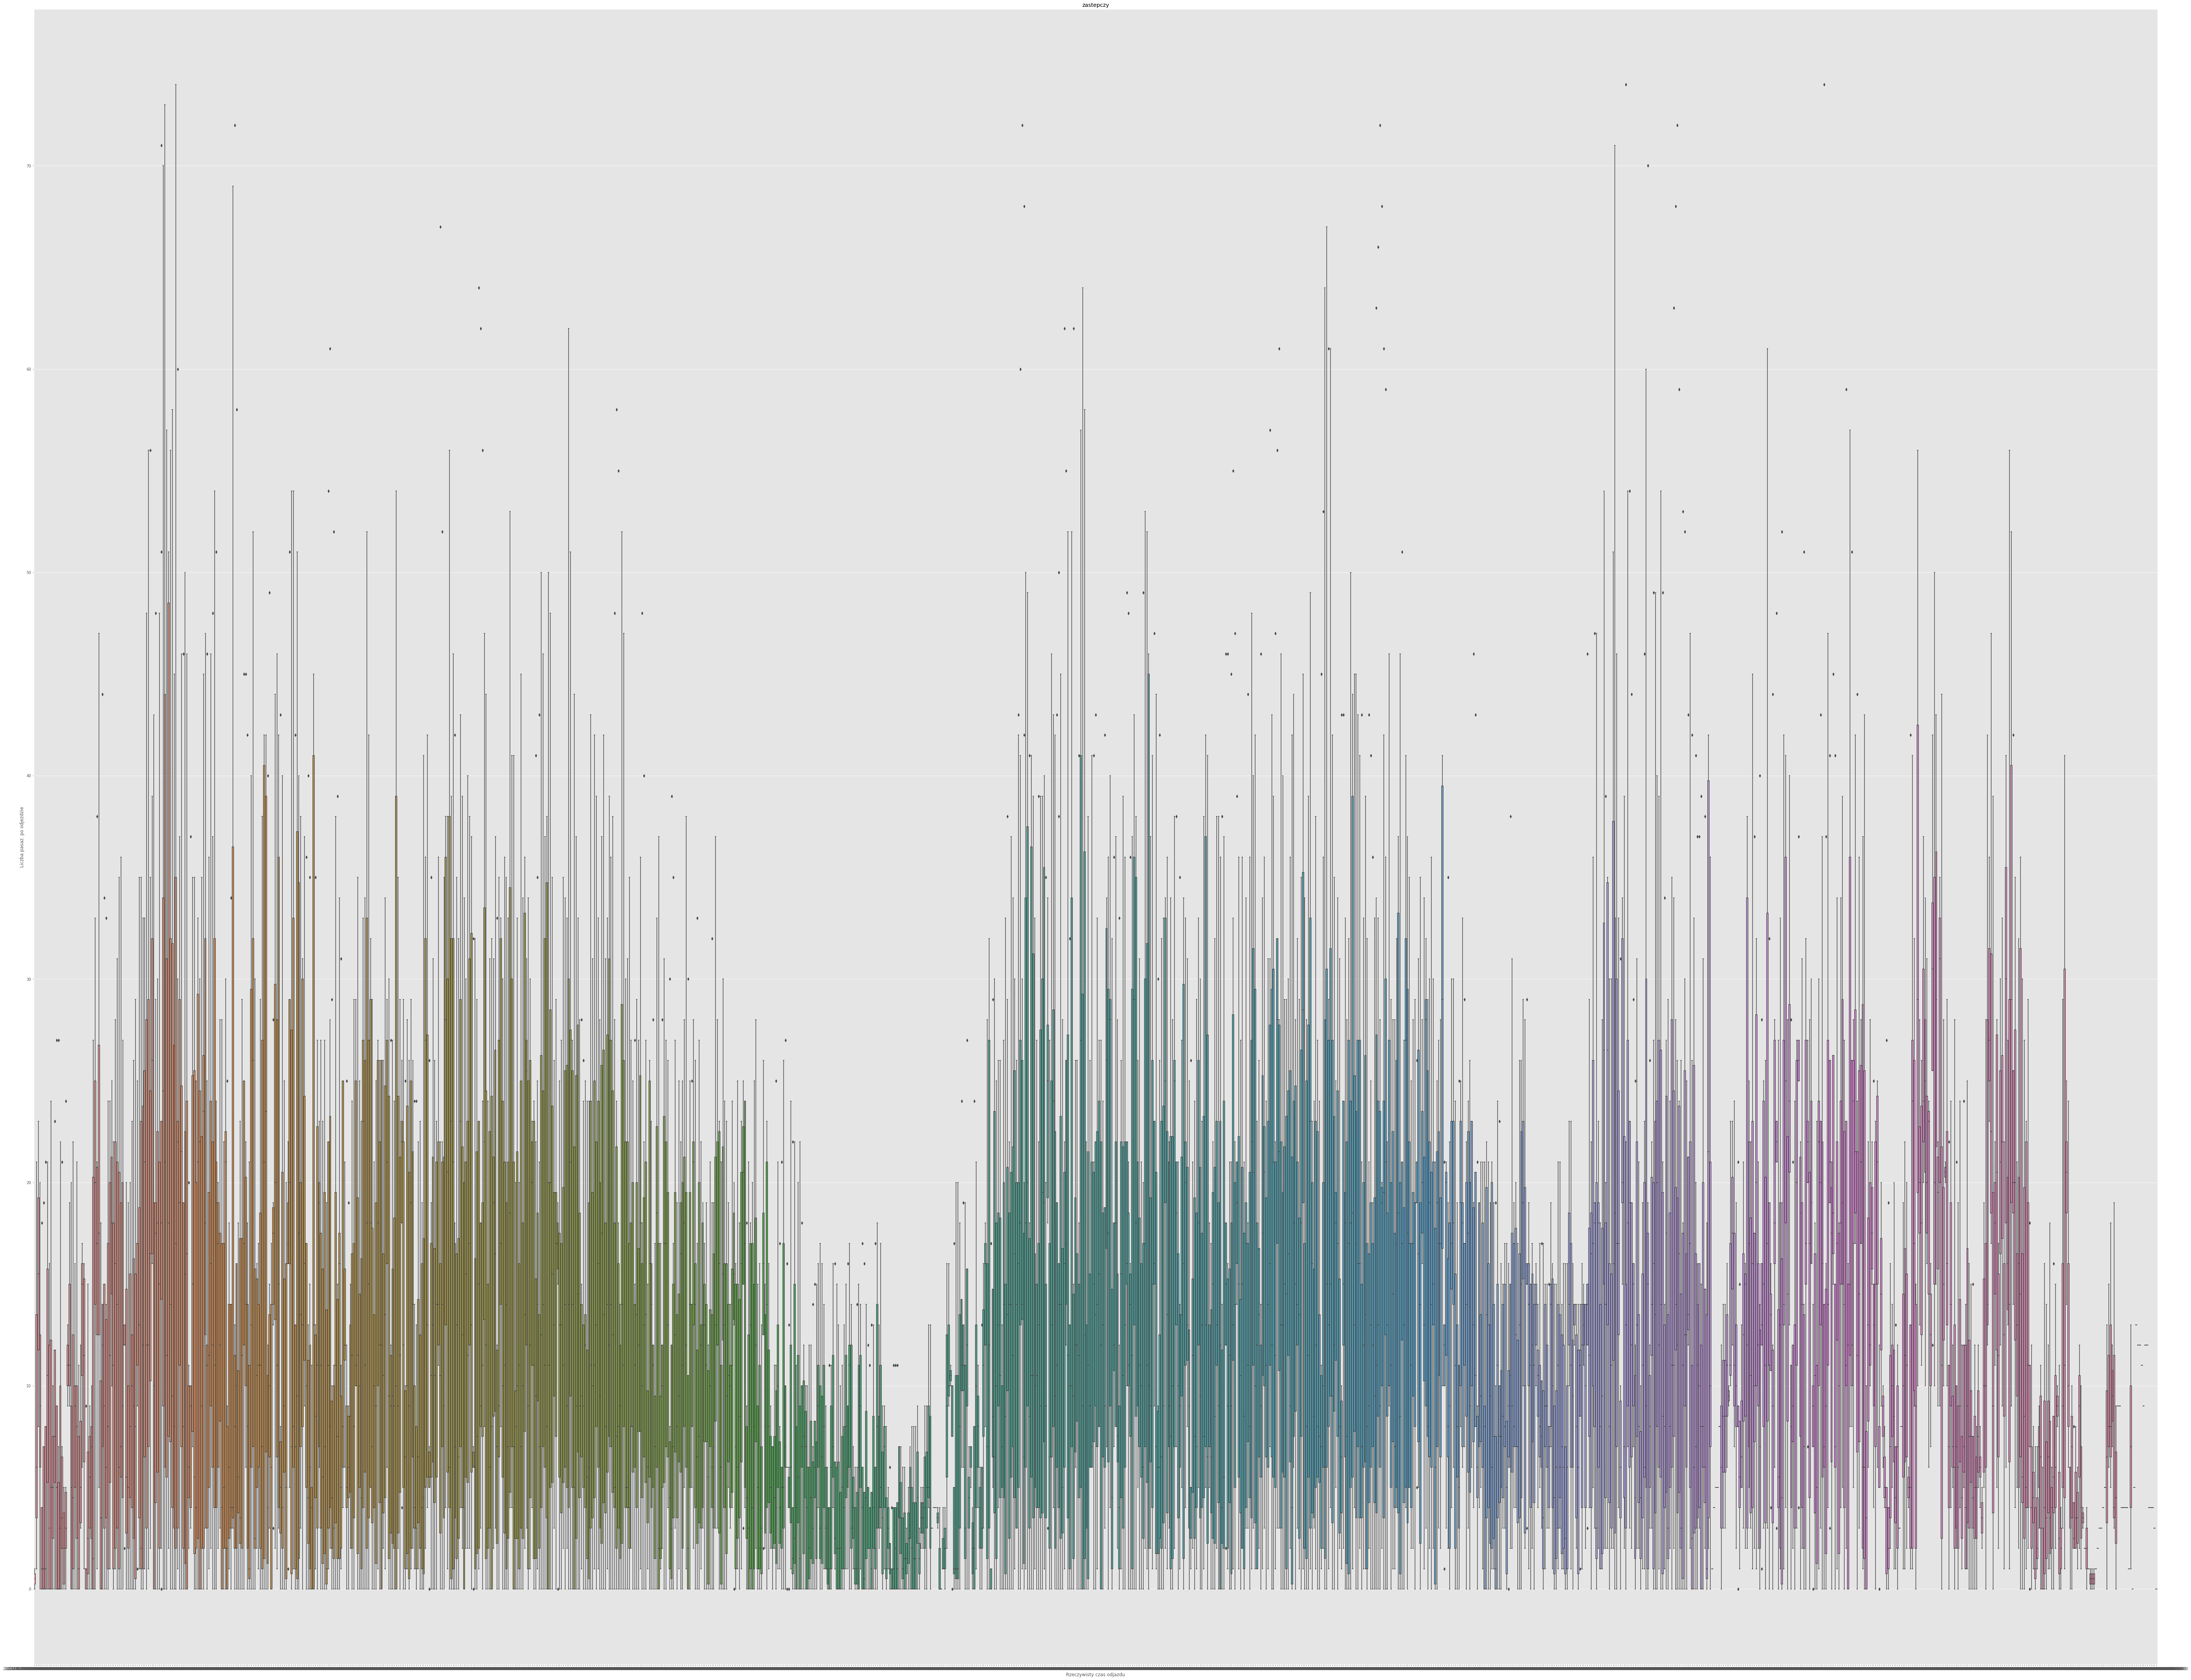

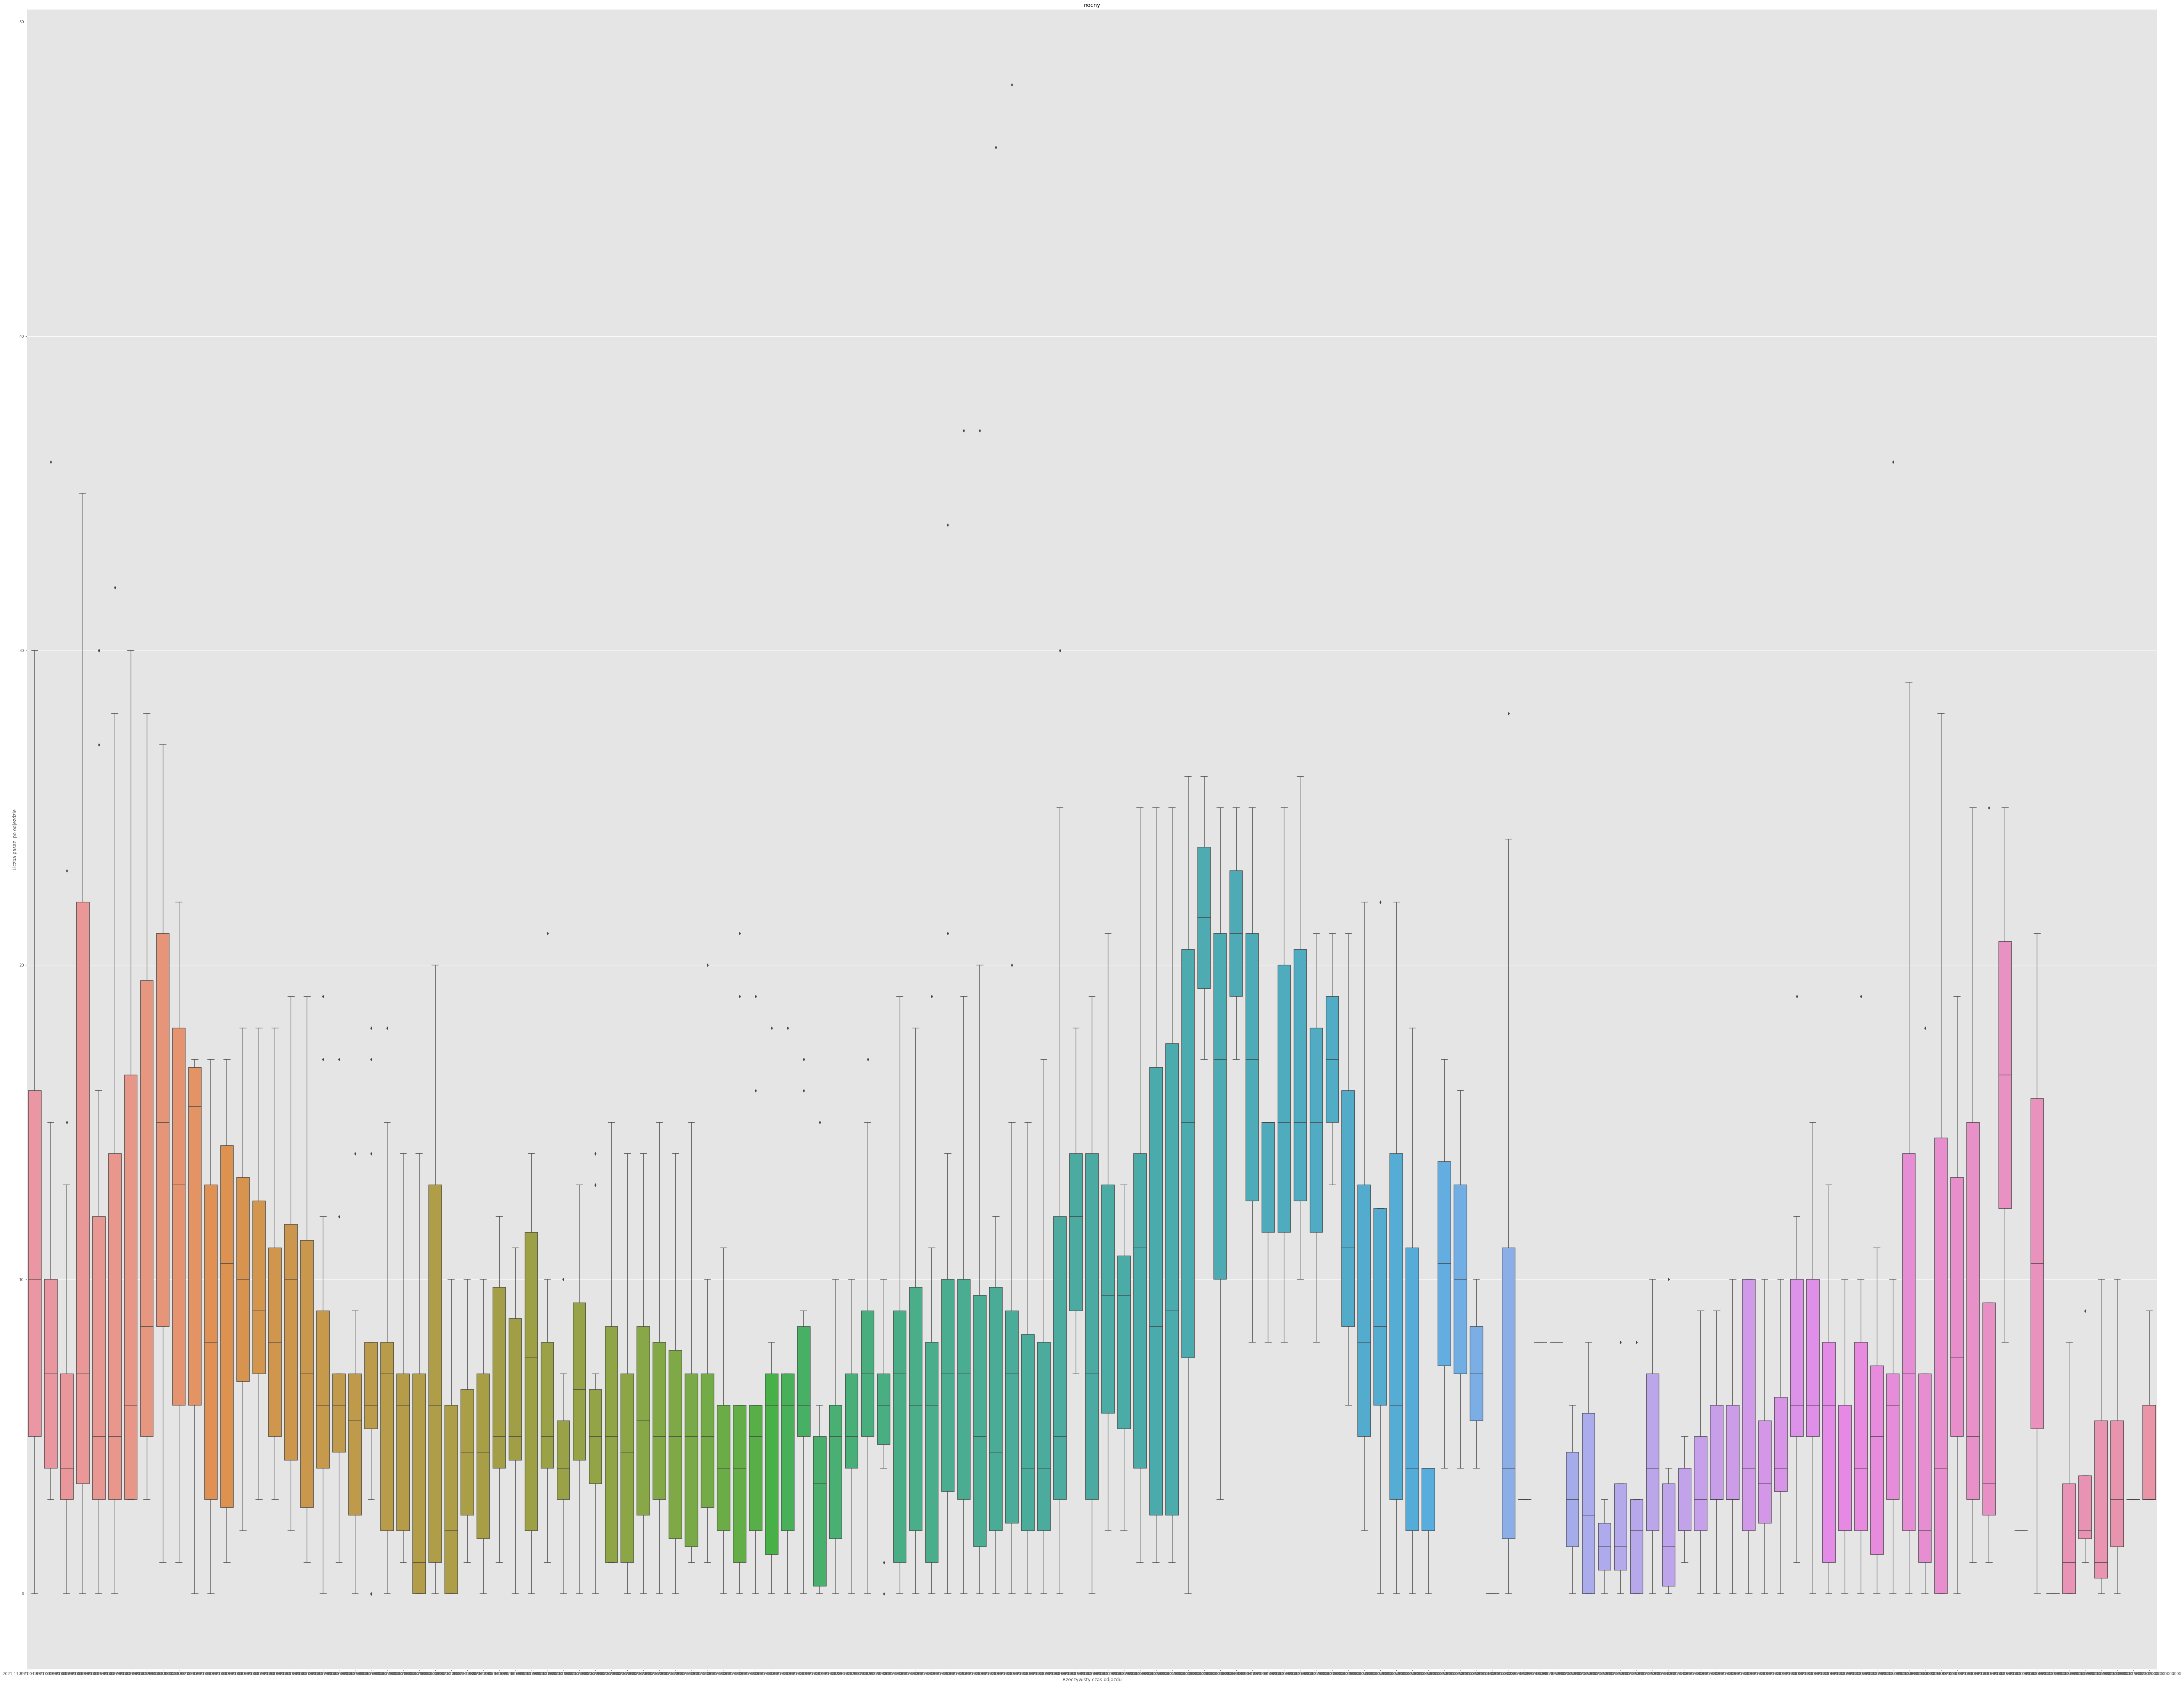

In [19]:
for trans_type in ['autobus', 'zastepczy', 'nocny']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Rzeczywisty czas odjazdu',
        y='Liczba pasaz. po odjezdzie',
        data=df.loc[df['Typ']==trans_type]
    )
    ax.set_title(trans_type)

# 6. Clustering

In [16]:
def find_clusters(speeds, iterations, df, column):
    k = len(speeds)
    data = np.array(df[column]).reshape(1,-1).T
    clusters = KMeans(
        n_clusters = k,
        max_iter = iterations,
        random_state = RANDOM_SEED
    ).fit(data)
    
    cc, *_ = clusters.cluster_centers_.reshape(1,k)
    cc_ord = np.argsort(cc)
    class_mapping = dict(zip(cc_ord, speeds))
    
    df['class'] = clusters.labels_
    df['class'] = df['class'].map(class_mapping)
    
    return df

In [17]:
crowding = ['low', 'medium', 'high']
iterations = 10

df = find_clusters(crowding, iterations, df, 'Liczba pasaz. po odjezdzie')

<Figure size 720x576 with 0 Axes>

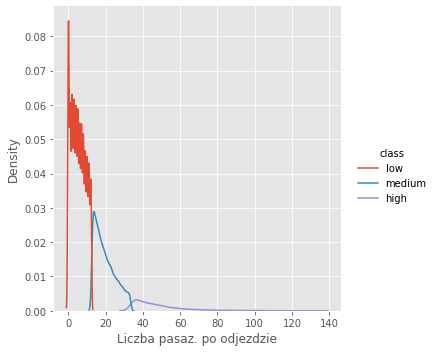

In [18]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x='Liczba pasaz. po odjezdzie',
    hue='class',
    kind='kde'
)

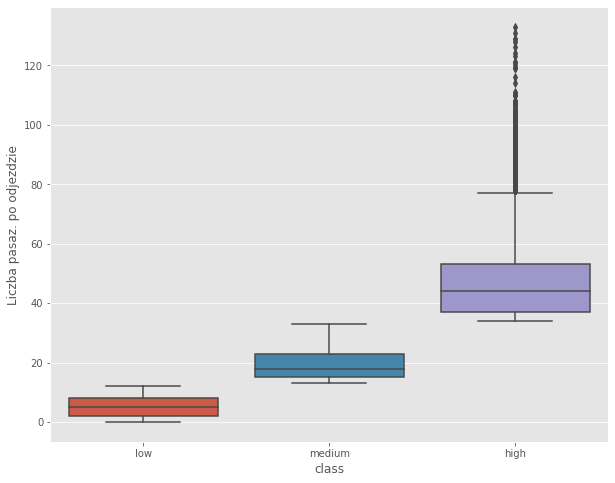

In [19]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    x='class',
    order=crowding,
    y='Liczba pasaz. po odjezdzie',
    data=df
)

# 5. Klasyfikacja wielomianowa (Polynomial Classifiers) - zle


In [13]:
from numpy import asarray
from sklearn.preprocessing import PolynomialFeatures

In [14]:

# define the dataset
data = asarray([[2,3],[2,3],[2,3]])
print(data)
# perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree=2)
data = trans.fit_transform(data)
print(data)

[[2 3]
 [2 3]
 [2 3]]
[[1. 2. 3. 4. 6. 9.]
 [1. 2. 3. 4. 6. 9.]
 [1. 2. 3. 4. 6. 9.]]


In [15]:
df.head(1)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Typ
0,102,TP-EMP,2021-11-09 05:11:00,1,9415,PKP Olszynka Grochowska,4,2021-11-09 05:11:00,2021-11-09 05:11:00,0,0,1,1,autobus


In [16]:
df_polfeat = df[['Numer taborowy','Numer przystanku','Liczba pasaz. przed','Liczba wysiadających pasaz.','Liczba wsiadajacych pasaz.','Liczba pasaz. po odjezdzie']]
df_polfeat.head(3)

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
0,9415,4,0,0,1,1
1,9415,3,1,0,0,1
2,9415,1,1,0,2,3


In [17]:
deg = len(df_polfeat.columns)
arr = np.array(df_polfeat)

In [18]:
polynomialFeatures = PolynomialFeatures(degree=deg)
output = polynomialFeatures.fit_transform(arr)
print(output)


[[1.000e+00 9.415e+03 4.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]
 [1.000e+00 9.415e+03 3.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [1.000e+00 9.415e+03 1.000e+00 ... 3.240e+02 4.860e+02 7.290e+02]
 ...
 [1.000e+00 9.946e+03 1.000e+00 ... 0.000e+00 0.000e+00 6.400e+01]
 [1.000e+00 9.946e+03 1.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [1.000e+00 9.946e+03 1.000e+01 ... 0.000e+00 0.000e+00 0.000e+00]]


In [26]:
uniq = np.unique(np.array(df['Nr linii']))
uniq

array(['102', '103', '104', '106', '118', '122', '123', '127', '131',
       '132', '134', '135', '138', '140', '142', '149', '152', '153',
       '157', '159', '161', '164', '176', '177', '179', '181', '184',
       '185', '186', '190', '193', '194', '197', '199', '201', '203',
       '204', '207', '208', '209', '210', '211', '212', '219', '220',
       '225', '234', '239', '249', '256', '262', '264', '304', '305',
       '314', '320', '323', '326', '332', '339', '516', '517', '520',
       '522', '525', '707', '710', '712', '715', '719', '724', '729',
       '737', '739', '742', '743', '809', '900', 'N01', 'N02', 'N03',
       'N14', 'N25', 'N41', 'N42', 'N43', 'N64', 'N71', 'N91', 'Z-2',
       'Z23'], dtype=object)

In [25]:
len(uniq)

91